![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


filename_features = "UCI HAR Dataset/features.txt"
filename_labels = "UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "UCI HAR Dataset/train/y_train.txt"

filename_subtest = "UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "UCI HAR Dataset/test/X_test.txt"
filename_ytest = "UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")['nome_var']
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])['subject_id']
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])['subject_id']
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

C:\Users\winga\AppData\Local\Temp\ipykernel_13300\3875436412.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
C:\Users\winga\AppData\Local\Temp\ipykernel_13300\3875436412.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
C:\Users\winga\AppData\Local\Temp\ipykernel_13300\3875436412.py:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

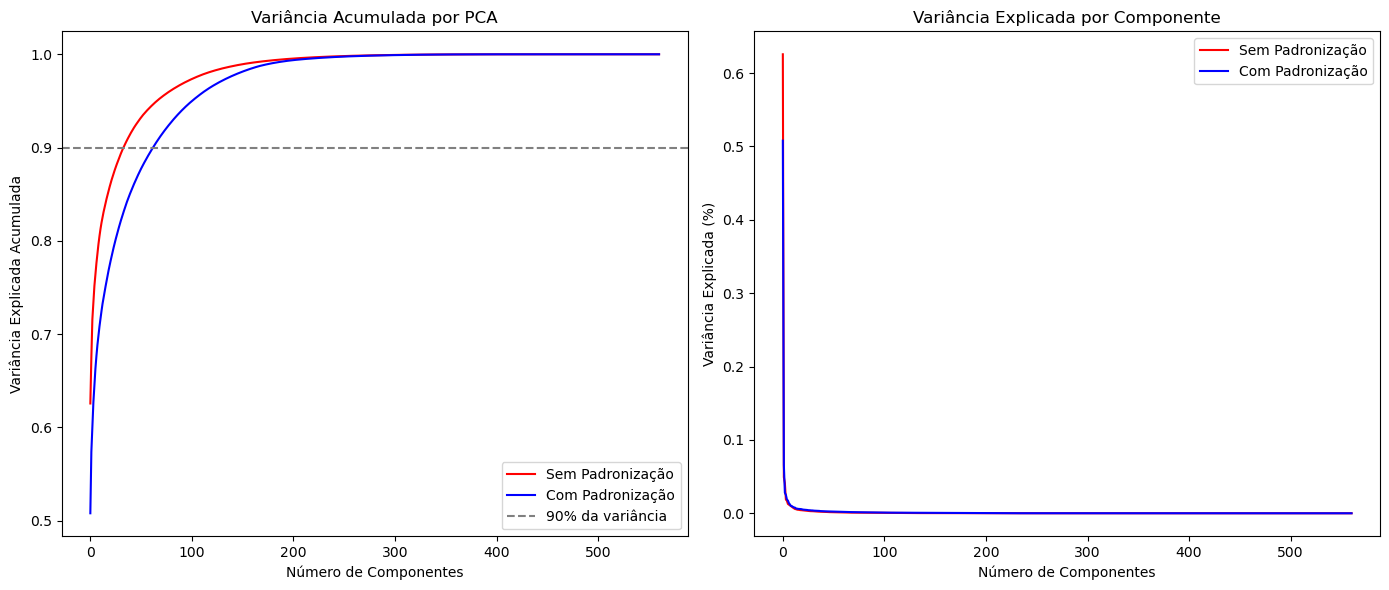

Componentes para 90% da variância:
- Sem padronização: 34 componentes
- Com padronização: 63 componentes
CPU times: total: 1.73 s
Wall time: 1.73 s


In [8]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

# PCA sem padronização
pca_sem = PCA()
pca_sem.fit(X_train)

# PCA com padronização
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

pca_com = PCA()
pca_com.fit(X_train_std)

# Variância explicada
var_explicada_sem = pca_sem.explained_variance_
var_percentual_sem = pca_sem.explained_variance_ratio_
var_acumulada_sem = np.cumsum(var_percentual_sem)

var_explicada_com = pca_com.explained_variance_
var_percentual_com = pca_com.explained_variance_ratio_
var_acumulada_com = np.cumsum(var_percentual_com)

# Plotando para comparação
plt.figure(figsize=(14,6))

# Variância acumulada
plt.subplot(1,2,1)
plt.plot(var_acumulada_sem, label='Sem Padronização', color='red')
plt.plot(var_acumulada_com, label='Com Padronização', color='blue')
plt.axhline(0.90, color='gray', linestyle='--', label='90% da variância')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Acumulada por PCA')
plt.legend()

# Variância percentual por componente
plt.subplot(1,2,2)
plt.plot(var_percentual_sem, label='Sem Padronização', color='red')
plt.plot(var_percentual_com, label='Com Padronização', color='blue')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada (%)')
plt.title('Variância Explicada por Componente')
plt.legend()

plt.tight_layout()
plt.show()

# Quantas componentes para 90%
n_comp_sem = np.argmax(var_acumulada_sem >= 0.90) + 1
n_comp_com = np.argmax(var_acumulada_com >= 0.90) + 1

print(f"Componentes para 90% da variância:")
print(f"- Sem padronização: {n_comp_sem} componentes")
print(f"- Com padronização: {n_comp_com} componentes")

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [9]:
%%time

# PCA sem padronização
pca_sem = PCA(n_components=10)
X_train_pca_sem = pca_sem.fit_transform(X_train)
X_test_pca_sem = pca_sem.transform(X_test)

# Árvore de decisão
tree_sem = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
tree_sem.fit(X_train_pca_sem, y_train)

# Previsões
y_pred_train_sem = tree_sem.predict(X_train_pca_sem)
y_pred_test_sem = tree_sem.predict(X_test_pca_sem)

# Acurácia
acc_train_sem = accuracy_score(y_train, y_pred_train_sem)
acc_test_sem = accuracy_score(y_test, y_pred_test_sem)

print("Árvore sem padronização:")
print(f"Acurácia treino: {acc_train_sem:.4f}")
print(f"Acurácia teste:  {acc_test_sem:.4f}")

Árvore sem padronização:
Acurácia treino: 0.8927
Acurácia teste:  0.8242
CPU times: total: 1 s
Wall time: 1.2 s


In [11]:
%%time
# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA com padronização
pca_com = PCA(n_components=10)
X_train_pca_com = pca_com.fit_transform(X_train_scaled)
X_test_pca_com = pca_com.transform(X_test_scaled)

# Árvore de decisão
tree_com = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
tree_com.fit(X_train_pca_com, y_train)

# Previsões
y_pred_train_com = tree_com.predict(X_train_pca_com)
y_pred_test_com = tree_com.predict(X_test_pca_com)

# Acurácia
acc_train_com = accuracy_score(y_train, y_pred_train_com)
acc_test_com = accuracy_score(y_test, y_pred_test_com)

print("Árvore com padronização:")
print(f"Acurácia treino: {acc_train_com:.4f}")
print(f"Acurácia teste:  {acc_test_com:.4f}")

Árvore com padronização:
Acurácia treino: 0.8587
Acurácia teste:  0.7672
CPU times: total: 672 ms
Wall time: 414 ms


a acurácia cai um pouco, porém é feita mais rápidamente.